# No1: Deep Learning Development Setup

In [ ]:
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import sklearn
import argparse
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from sklearn.preprocessing import normalize
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from datetime import datetime
from torch.autograd import Variable
from torchvision import models

# No2: Data Processing

## Input_to_lefse_after_filter_0.1%_non_metadata

### Load data

In [ ]:
# Read a CSV file from the specified path and load it into a pandas DataFrame.
# The file is located in a Google Drive directory and seems to be associated with a project called 'DeepCRC'.
df = pd.read_csv('/content/drive/MyDrive/code/DeepCRC/data/transposed_input_to_lefse_after_filter_0.1%_non_metadata.csv')

df

,Tax,disease,k__Archaea,k__Bacteria,k__Archaea|p__Euryarchaeota,k__Bacteria|p__Actinobacteria,k__Bacteria|p__Bacteroidetes,k__Bacteria|p__Candidatus_Melainabacteria,k__Bacteria|p__Firmicutes,k__Bacteria|p__Fusobacteria,...,k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Alphaproteobacteria_unclassified|f__Alphaproteobacteria_unclassified|g__GGB6606|s__GGB6606_SGB9340,k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Alphaproteobacteria_unclassified|f__Alphaproteobacteria_unclassified|g__GGB6608|s__GGB6608_SGB9342,k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Alphaproteobacteria_unclassified|f__Alphaproteobacteria_unclassified|g__GGB6612|s__GGB6612_SGB9346,k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Alphaproteobacteria_unclassified|f__Alphaproteobacteria_unclassified|g__GGB6613|s__GGB6613_SGB9347,k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Sutterellaceae|g__Sutterella|s__Sutterella_wadsworthensis,k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfovibrionales|f__Desulfovibrionaceae|g__Bilophila|s__Bilophila_wadsworthia,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Escherichia|s__Escherichia_coli,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Klebsiella|s__Klebsiella_pneumoniae,k__Bacteria|p__Verrucomicrobia|c__CFGB2165|o__OFGB2165|f__FGB2165|g__GGB6133|s__GGB6133_SGB8780,k__Bacteria|p__Verrucomicrobia|c__Verrucomicrobiae|o__Verrucomicrobiales|f__Akkermansiaceae|g__Akkermansia|s__Akkermansia_muciniphila
0,s1,1,0.905710,99.094290,0.905710,1.784360,7.873849,0.00000,68.444103,0.00371,...,0.0,0.0,0.00000,0.00000,0.00053,0.14372,7.279819,0.123070,0.00000,12.008619
1,s2,1,0.000000,100.000000,0.000000,0.705450,19.641682,0.00000,70.709512,0.51829,...,0.0,0.0,0.00000,0.00000,0.01561,0.07765,0.079380,1.897931,0.00000,5.689073
2,s3,1,9.866740,90.133260,9.866740,29.167290,6.524040,0.00000,53.272210,0.01782,...,0.0,0.0,0.00000,0.00000,0.02198,0.02230,0.268450,0.000000,0.00000,0.004570
3,s4,1,0.000000,100.000000,0.000000,3.917661,17.897994,0.00000,73.295255,0.02837,...,0.0,0.0,0.00000,0.00000,0.00000,1.02387,0.418530,0.010670,0.00000,3.184701
4,s5,1,0.000000,100.000000,0.000000,3.792974,9.402980,0.00000,82.568221,0.00000,...,0.0,0.0,0.11809,0.00730,0.02600,0.13702,0.057120,0.066920,0.10397,3.546984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1286,s1287,0,19.347202,80.652798,19.347202,4.457018,15.390334,0.00000,59.438806,0.00000,...,0.0,0.0,0.00000,0.00000,0.00982,0.00000,0.089040,0.000000,0.00000,0.009020
1287,s1288,0,0.000000,100.000000,0.000000,1.874050,32.522120,0.36443,59.859870,0.00000,...,0.0,0.0,0.00000,0.00813,0.00000,0.04022,0.484070,0.284910,0.00000,0.000000
1288,s1289,0,0.000000,100.000000,0.000000,1.886780,32.469707,0.36309,59.928414,0.00000,...,0.0,0.0,0.00000,0.01156,0.00000,0.03817,0.490270,0.300120,0.00000,0.000000
1289,s1290,0,0.000000,100.000000,0.000000,1.875599,32.569307,0.36268,59.841096,0.00000,...,0.0,0.0,0.00000,0.00935,0.00000,0.03317,0.483830,0.314460,0.00000,0.000000


### Feature encoding and normalization

In [ ]:
# Filtering features that start with 'k__'
k_features = df.filter(regex='^k__')

# Perform L2 normalization on these features
k_features_normalized = normalize(k_features, axis=0, norm='l2')

# Convert the normalized features back into a DataFrame, ensuring column names remain unchanged
k_features_normalized_df = pd.DataFrame(k_features_normalized, columns=k_features.columns)

# Merge 'Tax' and 'disease' columns with the normalized features
df = pd.concat([df[['Tax', 'disease']], k_features_normalized_df], axis=1)

df

,Tax,disease,k__Archaea,k__Bacteria,k__Archaea|p__Euryarchaeota,k__Bacteria|p__Actinobacteria,k__Bacteria|p__Bacteroidetes,k__Bacteria|p__Candidatus_Melainabacteria,k__Bacteria|p__Firmicutes,k__Bacteria|p__Fusobacteria,...,k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Alphaproteobacteria_unclassified|f__Alphaproteobacteria_unclassified|g__GGB6606|s__GGB6606_SGB9340,k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Alphaproteobacteria_unclassified|f__Alphaproteobacteria_unclassified|g__GGB6608|s__GGB6608_SGB9342,k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Alphaproteobacteria_unclassified|f__Alphaproteobacteria_unclassified|g__GGB6612|s__GGB6612_SGB9346,k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Alphaproteobacteria_unclassified|f__Alphaproteobacteria_unclassified|g__GGB6613|s__GGB6613_SGB9347,k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Sutterellaceae|g__Sutterella|s__Sutterella_wadsworthensis,k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfovibrionales|f__Desulfovibrionaceae|g__Bilophila|s__Bilophila_wadsworthia,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Escherichia|s__Escherichia_coli,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Klebsiella|s__Klebsiella_pneumoniae,k__Bacteria|p__Verrucomicrobia|c__CFGB2165|o__OFGB2165|f__FGB2165|g__GGB6133|s__GGB6133_SGB8780,k__Bacteria|p__Verrucomicrobia|c__Verrucomicrobiae|o__Verrucomicrobiales|f__Akkermansiaceae|g__Akkermansia|s__Akkermansia_muciniphila
0,s1,1,0.014452,0.027706,0.014897,0.011028,0.005658,0.000000,0.032080,0.000030,...,0.0,0.0,0.000000,0.000000,0.000008,0.012926,0.047153,0.003840,0.000000,0.108923
1,s2,1,0.000000,0.027960,0.000000,0.004360,0.014114,0.000000,0.033142,0.004189,...,0.0,0.0,0.000000,0.000000,0.000233,0.006984,0.000514,0.059225,0.000000,0.051602
2,s3,1,0.157438,0.025201,0.162289,0.180273,0.004688,0.000000,0.024969,0.000144,...,0.0,0.0,0.000000,0.000000,0.000328,0.002006,0.001739,0.000000,0.000000,0.000041
3,s4,1,0.000000,0.027960,0.000000,0.024214,0.012861,0.000000,0.034354,0.000229,...,0.0,0.0,0.000000,0.000000,0.000000,0.092085,0.002711,0.000333,0.000000,0.028886
4,s5,1,0.000000,0.027960,0.000000,0.023443,0.006757,0.000000,0.038700,0.000000,...,0.0,0.0,0.003054,0.000483,0.000388,0.012323,0.000370,0.002088,0.001168,0.032172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1286,s1287,0,0.308713,0.022550,0.318224,0.027547,0.011059,0.000000,0.027859,0.000000,...,0.0,0.0,0.000000,0.000000,0.000147,0.000000,0.000577,0.000000,0.000000,0.000082
1287,s1288,0,0.000000,0.027960,0.000000,0.011583,0.023369,0.015332,0.028056,0.000000,...,0.0,0.0,0.000000,0.000537,0.000000,0.003617,0.003135,0.008891,0.000000,0.000000
1288,s1289,0,0.000000,0.027960,0.000000,0.011662,0.023331,0.015276,0.028088,0.000000,...,0.0,0.0,0.000000,0.000764,0.000000,0.003433,0.003176,0.009365,0.000000,0.000000
1289,s1290,0,0.000000,0.027960,0.000000,0.011592,0.023403,0.015259,0.028048,0.000000,...,0.0,0.0,0.000000,0.000618,0.000000,0.002983,0.003134,0.009813,0.000000,0.000000


## After_lefse_after_filter_0.1%_metadata

### Load data

In [ ]:
# This file also includes metadata, which typically contains additional information about the samples or experimental conditions.
df_merge = pd.read_csv('/content/drive/MyDrive/code/DeepCRC/data/transposed_after_lefse_after_filter_0.1%_metadata.csv')

df_merge

,Tax,disease,age,bmi,country,sex,k__Archaea,k__Bacteria,k__Archaea|p__Euryarchaeota,k__Bacteria|p__Actinobacteria,...,k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales|f__Veillonellaceae|g__Dialister|s__Dialister_invisus,k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Fusobacteriaceae|g__Fusobacterium|s__Fusobacterium_gonidiaformans,k__Bacteria|p__Planctomycetes|c__Planctomycetia|o__Pirellulales|f__Pirellulaceae|g__GGB6601|s__GGB6601_SGB9333,k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Alphaproteobacteria_unclassified|f__Alphaproteobacteria_unclassified|g__GGB6606|s__GGB6606_SGB9340,k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Alphaproteobacteria_unclassified|f__Alphaproteobacteria_unclassified|g__GGB6613|s__GGB6613_SGB9347,k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Sutterellaceae|g__Sutterella|s__Sutterella_wadsworthensis,k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfovibrionales|f__Desulfovibrionaceae|g__Bilophila|s__Bilophila_wadsworthia,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Escherichia|s__Escherichia_coli,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Klebsiella|s__Klebsiella_pneumoniae,k__Bacteria|p__Verrucomicrobia|c__CFGB2165|o__OFGB2165|f__FGB2165|g__GGB6133|s__GGB6133_SGB8780
0,s1,1,64,23.1,China,0,0.905710,99.094290,0.905710,1.784360,...,0.000000,0.0,0.000000,0.0,0.00000,0.00053,0.14372,7.279819,0.123070,0.00000
1,s2,1,73,23.8,China,0,0.000000,100.000000,0.000000,0.705450,...,0.000000,0.0,0.000000,0.0,0.00000,0.01561,0.07765,0.079380,1.897931,0.00000
2,s3,1,67,24.7,China,1,9.866740,90.133260,9.866740,29.167290,...,0.000000,0.0,0.000000,0.0,0.00000,0.02198,0.02230,0.268450,0.000000,0.00000
3,s4,1,56,25.6,China,0,0.000000,100.000000,0.000000,3.917661,...,0.000000,0.0,0.000000,0.0,0.00000,0.00000,1.02387,0.418530,0.010670,0.00000
4,s5,1,59,20.7,China,1,0.000000,100.000000,0.000000,3.792974,...,0.000000,0.0,0.000000,0.0,0.00730,0.02600,0.13702,0.057120,0.066920,0.10397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1286,s1287,0,68,23.0,Germany,0,19.347202,80.652798,19.347202,4.457018,...,0.000000,0.0,0.000000,0.0,0.00000,0.00982,0.00000,0.089040,0.000000,0.00000
1287,s1288,0,53,31.0,Germany,1,0.000000,100.000000,0.000000,1.874050,...,0.016570,0.0,2.087940,0.0,0.00813,0.00000,0.04022,0.484070,0.284910,0.00000
1288,s1289,0,53,31.0,Germany,1,0.000000,100.000000,0.000000,1.886780,...,0.024850,0.0,2.017150,0.0,0.01156,0.00000,0.03817,0.490270,0.300120,0.00000
1289,s1290,0,53,31.0,Germany,1,0.000000,100.000000,0.000000,1.875599,...,0.013820,0.0,2.036209,0.0,0.00935,0.00000,0.03317,0.483830,0.314460,0.00000


### Feature encoding and normalization

In [ ]:
# Filtering features starting with 'k__'
k_features = df_merge.filter(regex='^k__')

# Perform L2 normalization on these features
k_features_normalized = normalize(k_features, axis=0, norm='l2')

k_features_normalized_df_merge = pd.DataFrame(k_features_normalized, columns=k_features.columns)

# Merge demographic and disease-related columns with the normalized features
df_merge = pd.concat([df_merge[['Tax', 'disease', 'age', 'bmi', 'country', 'sex']], k_features_normalized_df_merge], axis=1)

df_merge

,Tax,disease,age,bmi,country,sex,k__Archaea,k__Bacteria,k__Archaea|p__Euryarchaeota,k__Bacteria|p__Actinobacteria,...,k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales|f__Veillonellaceae|g__Dialister|s__Dialister_invisus,k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Fusobacteriaceae|g__Fusobacterium|s__Fusobacterium_gonidiaformans,k__Bacteria|p__Planctomycetes|c__Planctomycetia|o__Pirellulales|f__Pirellulaceae|g__GGB6601|s__GGB6601_SGB9333,k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Alphaproteobacteria_unclassified|f__Alphaproteobacteria_unclassified|g__GGB6606|s__GGB6606_SGB9340,k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Alphaproteobacteria_unclassified|f__Alphaproteobacteria_unclassified|g__GGB6613|s__GGB6613_SGB9347,k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Sutterellaceae|g__Sutterella|s__Sutterella_wadsworthensis,k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfovibrionales|f__Desulfovibrionaceae|g__Bilophila|s__Bilophila_wadsworthia,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Escherichia|s__Escherichia_coli,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Klebsiella|s__Klebsiella_pneumoniae,k__Bacteria|p__Verrucomicrobia|c__CFGB2165|o__OFGB2165|f__FGB2165|g__GGB6133|s__GGB6133_SGB8780
0,s1,1,64,23.1,China,0,0.014452,0.027706,0.014897,0.011028,...,0.000000,0.0,0.000000,0.0,0.000000,0.000008,0.012926,0.047153,0.003840,0.000000
1,s2,1,73,23.8,China,0,0.000000,0.027960,0.000000,0.004360,...,0.000000,0.0,0.000000,0.0,0.000000,0.000233,0.006984,0.000514,0.059225,0.000000
2,s3,1,67,24.7,China,1,0.157438,0.025201,0.162289,0.180273,...,0.000000,0.0,0.000000,0.0,0.000000,0.000328,0.002006,0.001739,0.000000,0.000000
3,s4,1,56,25.6,China,0,0.000000,0.027960,0.000000,0.024214,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.092085,0.002711,0.000333,0.000000
4,s5,1,59,20.7,China,1,0.000000,0.027960,0.000000,0.023443,...,0.000000,0.0,0.000000,0.0,0.000483,0.000388,0.012323,0.000370,0.002088,0.001168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1286,s1287,0,68,23.0,Germany,0,0.308713,0.022550,0.318224,0.027547,...,0.000000,0.0,0.000000,0.0,0.000000,0.000147,0.000000,0.000577,0.000000,0.000000
1287,s1288,0,53,31.0,Germany,1,0.000000,0.027960,0.000000,0.011583,...,0.000372,0.0,0.093190,0.0,0.000537,0.000000,0.003617,0.003135,0.008891,0.000000
1288,s1289,0,53,31.0,Germany,1,0.000000,0.027960,0.000000,0.011662,...,0.000557,0.0,0.090030,0.0,0.000764,0.000000,0.003433,0.003176,0.009365,0.000000
1289,s1290,0,53,31.0,Germany,1,0.000000,0.027960,0.000000,0.011592,...,0.000310,0.0,0.090881,0.0,0.000618,0.000000,0.002983,0.003134,0.009813,0.000000


In [ ]:
# Check for missing values in the 'bmi' column of the DataFrame
has_missing_values = df_merge['bmi'].isnull().any()

if has_missing_values:
    print("Yes")
else:
    print("No")

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# Handling missing values for 'bmi'
imputer = SimpleImputer(strategy='mean')
df_merge['bmi'] = imputer.fit_transform(df_merge[['bmi']].values)

# Categorical encoding for 'country' column
df_merge['country'] = df_merge['country'].astype('category').cat.codes

# Normalize 'age' and 'bmi' columns using L2 normalization
scaler = MinMaxScaler()
df_merge[['age', 'bmi']] = scaler.fit_transform(df_merge[['age', 'bmi']])

df_merge

,Tax,disease,age,bmi,country,sex,k__Archaea,k__Bacteria,k__Archaea|p__Euryarchaeota,k__Bacteria|p__Actinobacteria,...,k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales|f__Veillonellaceae|g__Dialister|s__Dialister_invisus,k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Fusobacteriaceae|g__Fusobacterium|s__Fusobacterium_gonidiaformans,k__Bacteria|p__Planctomycetes|c__Planctomycetia|o__Pirellulales|f__Pirellulaceae|g__GGB6601|s__GGB6601_SGB9333,k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Alphaproteobacteria_unclassified|f__Alphaproteobacteria_unclassified|g__GGB6606|s__GGB6606_SGB9340,k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Alphaproteobacteria_unclassified|f__Alphaproteobacteria_unclassified|g__GGB6613|s__GGB6613_SGB9347,k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Sutterellaceae|g__Sutterella|s__Sutterella_wadsworthensis,k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfovibrionales|f__Desulfovibrionaceae|g__Bilophila|s__Bilophila_wadsworthia,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Escherichia|s__Escherichia_coli,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Klebsiella|s__Klebsiella_pneumoniae,k__Bacteria|p__Verrucomicrobia|c__CFGB2165|o__OFGB2165|f__FGB2165|g__GGB6133|s__GGB6133_SGB8780
0,s1,1,0.609375,0.270760,0,0,0.014452,0.027706,0.014897,0.011028,...,0.000000,0.0,0.000000,0.0,0.000000,0.000008,0.012926,0.047153,0.003840,0.000000
1,s2,1,0.750000,0.300965,0,0,0.000000,0.027960,0.000000,0.004360,...,0.000000,0.0,0.000000,0.0,0.000000,0.000233,0.006984,0.000514,0.059225,0.000000
2,s3,1,0.656250,0.339801,0,1,0.157438,0.025201,0.162289,0.180273,...,0.000000,0.0,0.000000,0.0,0.000000,0.000328,0.002006,0.001739,0.000000,0.000000
3,s4,1,0.484375,0.378636,0,0,0.000000,0.027960,0.000000,0.024214,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.092085,0.002711,0.000333,0.000000
4,s5,1,0.531250,0.167199,0,1,0.000000,0.027960,0.000000,0.023443,...,0.000000,0.0,0.000000,0.0,0.000483,0.000388,0.012323,0.000370,0.002088,0.001168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1286,s1287,0,0.671875,0.266445,2,0,0.308713,0.022550,0.318224,0.027547,...,0.000000,0.0,0.000000,0.0,0.000000,0.000147,0.000000,0.000577,0.000000,0.000000
1287,s1288,0,0.437500,0.611647,2,1,0.000000,0.027960,0.000000,0.011583,...,0.000372,0.0,0.093190,0.0,0.000537,0.000000,0.003617,0.003135,0.008891,0.000000
1288,s1289,0,0.437500,0.611647,2,1,0.000000,0.027960,0.000000,0.011662,...,0.000557,0.0,0.090030,0.0,0.000764,0.000000,0.003433,0.003176,0.009365,0.000000
1289,s1290,0,0.437500,0.611647,2,1,0.000000,0.027960,0.000000,0.011592,...,0.000310,0.0,0.090881,0.0,0.000618,0.000000,0.002983,0.003134,0.009813,0.000000


# No3: Model Construction

In [ ]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_dim, n_classes, layers, dropout=False, dropout_rate=0.6):
        # Initialize the neural network as a subclass of nn.Module
        super(Net, self).__init__()

        # Store the network parameters
        self.indim = input_size
        self.hidden = hidden_dim
        self.hdims = layers
        self.n_classes = n_classes
        self.dropout = dropout
        self.dropout_rate = dropout_rate

        # Dynamically create the layers of the neural network
        current_dim = input_size
        self.layers = nn.ModuleList()
        for dimension in range(self.hdims):
            self.layers.append(nn.Linear(current_dim,self.hidden)) # Linear transformation layer
            current_dim = self.hidden
            if dropout:                      # Optionally add a dropout layer after each linear layer
                self.layers.append(nn.Dropout(p=self.dropout_rate))


        self.output = nn.Linear(self.hidden,n_classes)        # Linear layer for output


    def forward(self, X):

        if isinstance(X, np.ndarray):                 # Check if input is a NumPy array and convert it to a torch Tensor if necessary
            X = torch.from_numpy(X.astype(np.float32))

        # Initialize a tensor to hold the scores for each input in the batch
        scores = Variable(torch.zeros((X.shape[0],self.n_classes)), requires_grad=False)
        for i in range(X.shape[0]):
            x = X[i]
            x = x.view(-1,self.indim)
            for j,l in enumerate(self.layers):
                x = F.elu(self.layers[j](x)+l(x))
            x = F.softmax(self.output(x), dim=1)
            scores[i] = x
        return scores                         # Return the scores tensor containing class probabilities for each input

# No4: Gridsearch for Model

In [ ]:
# Initialize variables to keep track of the best model and accuracy
count = 0
best_accuracy = 0
best_model = None


# Loop over a specified number of iterations to perform random searches on hyperparameters
for iteration in range(gridsearch_iters):
        # Generate random parameters from set ranges
        dropout_rate=0.5
        n_layers = np.random.randint(5,75)              # random number of layers between 5 and 75
        n_neurons = np.random.randint(5,75)              # random number of neurons per layer between 5 and 75
        use_dropout=np.random.choice([True,False])
        if use_dropout:
                dropout_rate=np.random.uniform(0.1,0.9)
        learning_rate = np.random.uniform(0.000005,0.00005)     # random learning rate
        weight_decay = np.random.uniform(0,0.1)           # random weight decay


        # Initialize the model with random parameters
        model = Net(row_size, n_neurons, classes, n_layers)


        # Setup the optimizer with the selected parameters
        optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)
        model.train()


        # Training loop over the number of epochs
        for epoch in range(epochs):
                # Shuffle training data indices
                rnd_idx=np.random.permutation(x_train.shape[0])
                # Initialize lists to keep predictions for accuracy calculation
                train_pred, val_pred, test_pred = [], [], []


                # Batch training
                for rnd_indices in np.array_split(rnd_idx,x_train.shape[0]//batch_size):
                        x, target = Variable(x_train[rnd_indices]),Variable(y_train[rnd_indices])
                        optimizer.zero_grad()
                        output = model(x.float())
                        loss = criterion(output,target.long())
                        loss.backward()
                        optimizer.step()


                # Calculate predictions for accuracy measurement for training, validation, and test sets
                for row in range(x_train.shape[0]):
                        x, target = Variable(x_train[row]),Variable(y_train[row])
                        output = model(x.unsqueeze(dim=0).float())
                        train_pred.append(output.data.max(1,keepdim=True)[1].item())

                for row in range(x_val.shape[0]):
                        x,target=Variable(x_val[row]),Variable(y_val[row])
                        output = model(x.unsqueeze(dim=0).float())
                        val_pred.append(output.data.max(1,keepdim=True)[1].item())

                for row in range(x_test.shape[0]):
                        x,target=Variable(x_test[row]),Variable(y_test[row])
                        output = model(x.unsqueeze(dim=0).float())
                        test_pred.append(output.data.max(1,keepdim=True)[1].item())


                # Calculate and log accuracy
                test_accuracy = sklearn.metrics.accuracy_score(y_test,test_pred)
                val_accuracy = sklearn.metrics.accuracy_score(y_val,val_pred)
                train_accuracy = sklearn.metrics.accuracy_score(y_train,train_pred)


                # Logging the accuracies using TensorBoard
                writer.add_scalar('Accuracy/val',val_accuracy,epoch)
                writer.add_scalar('Accuracy/train',train_accuracy,epoch)
                writer.add_scalar('Accuracy/test',test_accuracy,epoch)


                # Print accuracies for each epoch
                val_accuracies.append(val_accuracy)
                train_accuracies.append(train_accuracy)
                print("Epoch number:",epoch+1," Training accuracy:",train_accuracy,"Validation accuracy:",val_accuracy, "Testing accuracy:",test_accuracy)



        # Update best model if current model is better
        if test_accuracy > best_accuracy:
                best_accuracy = test_accuracy
                best_params = {"n_layers":n_layers,"n_neurons":n_neurons,"use_dropout":use_dropout,
                                "dropout_rate":dropout_rate,"learning_rate":learning_rate,"weight_decay":weight_decay}
                best_model = model
        else:
                count +=1
                if count >= early_stop:
                        print("Best parameters:",best_params,"\n","Highest observed accuracy:",best_accuracy)
                        return best_model


# Print the best parameters and accuracy after all iterations
print("Best parameters:",best_params,"\n","Highest observed accuracy:",best_accuracy)

return best_model

# No5: Training Model

In [ ]:
data = df_merge

labels = data['disease'].values


# Extract the labels from the 'disease' column
data = data.drop(columns=['Tax', 'disease'])


# Filter out columns starting with 'k__' from the DataFrame
columns_to_keep = ~data.columns.str.startswith('k__')
filtered_data = data.loc[:, columns_to_keep]


data = data.drop(columns=['age', 'bmi', 'country', 'sex'])


# Select columns that start with 'k__', contain 's__', and do not contain 't__'
columns_to_filter2 = data.columns.str.startswith('k__') & data.columns.str.contains('s__') & ~data.columns.str.contains('t__')
filtered2_data = data.loc[:, columns_to_filter2]


# Concatenate
new_data = pd.concat([filtered_data, filtered2_data], axis=1)


feature_names = new_data.columns.tolist()                   # Extract feature names as a list


x_train = new_data.values.astype('float64')                   # Convert the new data into a NumPy array of type float64

In [ ]:
new_data

,age,bmi,country,sex,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_longum,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_pseudocatenulatum,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_caccae,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_cellulosilyticus,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_fragilis,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_intestinalis,...,k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales|f__Veillonellaceae|g__Dialister|s__Dialister_invisus,k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Fusobacteriaceae|g__Fusobacterium|s__Fusobacterium_gonidiaformans,k__Bacteria|p__Planctomycetes|c__Planctomycetia|o__Pirellulales|f__Pirellulaceae|g__GGB6601|s__GGB6601_SGB9333,k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Alphaproteobacteria_unclassified|f__Alphaproteobacteria_unclassified|g__GGB6606|s__GGB6606_SGB9340,k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Alphaproteobacteria_unclassified|f__Alphaproteobacteria_unclassified|g__GGB6613|s__GGB6613_SGB9347,k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Sutterellaceae|g__Sutterella|s__Sutterella_wadsworthensis,k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfovibrionales|f__Desulfovibrionaceae|g__Bilophila|s__Bilophila_wadsworthia,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Escherichia|s__Escherichia_coli,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Klebsiella|s__Klebsiella_pneumoniae,k__Bacteria|p__Verrucomicrobia|c__CFGB2165|o__OFGB2165|f__FGB2165|g__GGB6133|s__GGB6133_SGB8780
0,0.609375,0.270760,0,0,0.000000,0.000000,0.009777,0.000968,0.000962,0.000950,...,0.000000,0.0,0.000000,0.0,0.000000,0.000008,0.012926,0.047153,0.003840,0.000000
1,0.750000,0.300965,0,0,0.000325,0.006332,0.000039,0.002712,0.009325,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000233,0.006984,0.000514,0.059225,0.000000
2,0.656250,0.339801,0,1,0.033839,0.041184,0.000531,0.000000,0.000626,0.000218,...,0.000000,0.0,0.000000,0.0,0.000000,0.000328,0.002006,0.001739,0.000000,0.000000
3,0.484375,0.378636,0,0,0.005731,0.032445,0.000033,0.002244,0.003288,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.092085,0.002711,0.000333,0.000000
4,0.531250,0.167199,0,1,0.003636,0.010928,0.027136,0.000788,0.002461,0.006449,...,0.000000,0.0,0.000000,0.0,0.000483,0.000388,0.012323,0.000370,0.002088,0.001168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1286,0.671875,0.266445,2,0,0.002544,0.000000,0.013414,0.000000,0.000000,0.003978,...,0.000000,0.0,0.000000,0.0,0.000000,0.000147,0.000000,0.000577,0.000000,0.000000
1287,0.437500,0.611647,2,1,0.002424,0.000000,0.000000,0.001512,0.000861,0.000000,...,0.000372,0.0,0.093190,0.0,0.000537,0.000000,0.003617,0.003135,0.008891,0.000000
1288,0.437500,0.611647,2,1,0.002627,0.000000,0.000000,0.001654,0.000831,0.000000,...,0.000557,0.0,0.090030,0.0,0.000764,0.000000,0.003433,0.003176,0.009365,0.000000
1289,0.437500,0.611647,2,1,0.002612,0.000000,0.000000,0.001705,0.000788,0.000000,...,0.000310,0.0,0.090881,0.0,0.000618,0.000000,0.002983,0.003134,0.009813,0.000000


In [ ]:
# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_train, labels, test_size = 0.1, train_size = None, random_state=42, shuffle = True, stratify = labels)     #Split Data into training and validation

#Convert value types to integer for accuacy comparison
y_train = y_train.astype('int')
y_test = y_test.astype('int')

x_train, y_train, x_test, y_test = torch.from_numpy(x_train), torch.from_numpy(y_train), torch.from_numpy(x_test), torch.from_numpy(y_test)                   # Convert data from NumPy arrays to PyTorch tensors


In [ ]:
epochs = 35                 # Set the number of epochs

learning_rate = 0.0001            # Set the learning rate for the optimizer

batch_size = 50               # Define the batch size

Threshold = 0.03              # Set a threshold for a specific condition or a stopping criteria


In [ ]:
# Define a function to train the neural network model
def Train_model(x_train, y_train):
    # Determine the number of features and unique classes from the training data
    row_size = x_train.shape[1]
    unique = np.unique(y_train)
    classes = len(unique)

    x_train[x_train < Threshold] = 0.0

    # Set up the loss function for training
    criterion = nn.CrossEntropyLoss()
    model = Net(row_size, 75, classes, 15)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0)


    writer = SummaryWriter()                        # Initialize a SummaryWriter for TensorBoard logging

    # Begin training over a specified number of epochs
    for epoch in range(epochs):
        model.train()
        train_pred = []

        rnd_idx = np.random.permutation(x_train.shape[0])       # Randomly shuffle indices for training data
        # Training in batches
        for rnd_indices in np.array_split(rnd_idx, x_train.shape[0] // batch_size):
            x, target = Variable(x_train[rnd_indices]), Variable(y_train[rnd_indices])
            optimizer.zero_grad()
            output = model(x.float())
            loss = criterion(output, target.long())
            loss.backward()
            optimizer.step()

        # Evaluate training accuracy at the end of each epoch
        model.eval()
        with torch.no_grad():
            for row in range(x_train.shape[0]):         # Turn off gradients for validation, saves memory and computations
                x, target = Variable(x_train[row]), Variable(y_train[row])
                output = model(x.unsqueeze(dim=0).float())
                train_pred.append(output.data.max(1, keepdim=True)[1].item())
            train_accuracy = accuracy_score(y_train, train_pred)
            writer.add_scalar('Accuracy/train', train_accuracy, epoch)
            print(f"Epoch {epoch+1}/{epochs}: Training accuracy: {train_accuracy}")

    writer.close()
    return model        # Return the trained model


In [ ]:
# Call the training function with training data to train the model
model = Train_model(x_train, y_train)


Epoch 1/35: Training accuracy: 0.5624461670973299
Epoch 2/35: Training accuracy: 0.6106804478897502
Epoch 3/35: Training accuracy: 0.595176571920758
Epoch 4/35: Training accuracy: 0.6244616709732989
Epoch 5/35: Training accuracy: 0.6459948320413437
Epoch 6/35: Training accuracy: 0.8070628768303187
Epoch 7/35: Training accuracy: 0.8113695090439277
Epoch 8/35: Training accuracy: 0.8535745047372955
Epoch 9/35: Training accuracy: 0.8639104220499569
Epoch 10/35: Training accuracy: 0.8897502153316107
Epoch 11/35: Training accuracy: 0.8975021533161068
Epoch 12/35: Training accuracy: 0.8380706287683032
Epoch 13/35: Training accuracy: 0.9198966408268734
Epoch 14/35: Training accuracy: 0.9285099052540913
Epoch 15/35: Training accuracy: 0.8983634797588286
Epoch 16/35: Training accuracy: 0.9345391903531438
Epoch 17/35: Training accuracy: 0.9397071490094746
Epoch 18/35: Training accuracy: 0.9233419465977606
Epoch 19/35: Training accuracy: 0.9664082687338501
Epoch 20/35: Training accuracy: 0.9207579

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from torch.autograd import Variable
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay


plt.rcParams.update({'font.size': 10})  # Set a global font size for all matplotlib plots

def test_model(model, x_test, y_test):
    # Set the model to evaluation mode
    model.eval()
    test_pred = []
    test_scores = []


    # Disable gradient calculations for testing, which speeds up computations and reduces memory usage
    with torch.no_grad():
        for row in range(x_test.shape[0]):
            x, target = Variable(x_test[row]), Variable(y_test[row])
            # Forward pass: compute the model output
            output = model(x.unsqueeze(dim=0).float())
            # Assuming binary classification and the model outputs logits, apply sigmoid to convert to probabilities
            test_scores.append(torch.sigmoid(output).cpu().numpy()[0][1])
            # Store the predicted class (the class with the highest probability)
            test_pred.append(torch.argmax(output, dim=1).cpu().item())

    # Calculate accuracy using true labels and predicted labels
    test_accuracy = accuracy_score(y_test, test_pred)
    # Compute ROC AUC values
    fpr, tpr, thresholds = roc_curve(y_test, test_scores)  # Correctly unpack values here
    roc_auc = roc_auc_score(y_test, test_scores)

    print(f"Final Test Accuracy: {test_accuracy}")
    print(f"Final Test AUC Score: {roc_auc}")

    # Plot ROC Curve
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='#E3738B', lw=2, label='Clinical+117Species AUC = %0.3f' % roc_auc)
    plt.plot([0, 1], [0, 1], color='#F9D5DD', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Oranges)
    plt.title('Confusion Matrix')
    plt.show()


Final Test Accuracy: 0.9769230769230769
Final Test AUC Score: 0.9822998336897125


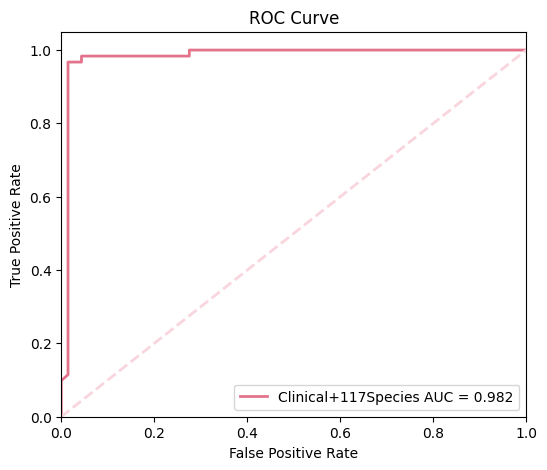

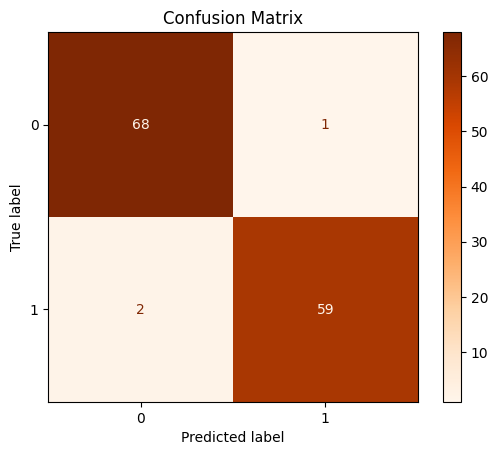

In [ ]:
test_model(model, x_test, y_test)

# No6: Saving Model

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/code/DeepCRC/model/117MergeMetadata_best.pt')

# No7: SHAP Explaier

In [ ]:
pip install shap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 6.4 MB/s eta 0:00:00


In [ ]:
import shap
import numpy as np
import torch

model.eval()

X_test_float = x_test.float()

# Initialize a GradientExplainer
explainer = shap.GradientExplainer(model, X_test_float)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_float)



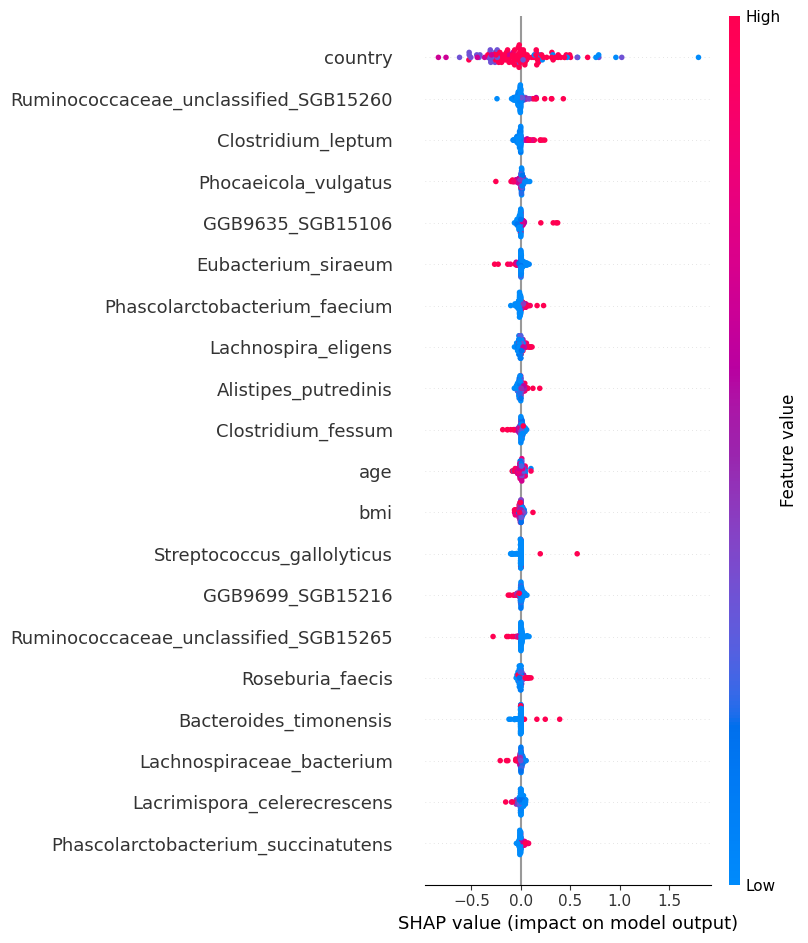

In [ ]:
# Select SHAP values for the positive class
shap_values_positive = shap_values[:, :, 1]

# Simplify feature names by removing certain prefixes
simplified_feature_names = [name.split('s__')[-1] if 's__' in name else name for name in feature_names]

# Generate a SHAP summary plot
shap.summary_plot(shap_values_positive, X_test_float, feature_names=simplified_feature_names)

# No8: DeepCRC vs Machine Learning

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

def train_svm(X_train, y_train):
    model = SVC(probability=True, random_state=42, C=5)
    model.fit(X_train, y_train)
    return model

def train_logistic_regression(X_train, y_train):
    model = LogisticRegression(random_state=42, max_iter=1000, C=15)
    model.fit(X_train, y_train)
    return model

def train_knn(X_train, y_train, neighbors=7):
    model = KNeighborsClassifier(n_neighbors=neighbors)
    model.fit(X_train, y_train)
    return model

def train_xgboost(X_train, y_train):
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_estimators=8)
    model.fit(X_train, y_train)
    return model


In [ ]:
# X_train, y_train

svm_model = train_svm(x_train, y_train)

logistic_model = train_logistic_regression(x_train, y_train)

knn_model = train_knn(x_train, y_train, neighbors=12)

xgb_model = train_xgboost(x_train, y_train)


In [ ]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from torch.autograd import Variable


plt.rcParams.update({'font.size': 10})

def test_models(models, x_test, y_test):
    plt.figure(figsize=(6, 5))

    colors = ['#FCB2AF', '#9BDFDF', '#FFE2CE', '#C4D8E9', '#BEBCDF']

    for (name, model), color in zip(models.items(), colors):
        test_scores = []
        test_pred = []
        if isinstance(model, torch.nn.Module):
            # Handling PyTorch model
            model.eval()
            with torch.no_grad():
                for x in x_test:  # Assume x_test is properly batched or adjust accordingly
                    x = Variable(x.unsqueeze(0).float())  # Ensure input is correct for the model
                    output = model(x)
                    prob = torch.sigmoid(output)[:, 1]  # Assume binary classification and model outputs logits for each class
                    pred = torch.argmax(output, dim=1)
                    test_scores.extend(prob.cpu().numpy())  # Convert to numpy array and store
                    test_pred.extend(pred.cpu().numpy())
        else:
            # Handling sklearn models or XGBoost
            test_scores = model.predict_proba(x_test)[:, 1]
            test_pred = model.predict(x_test)

        # Compute ROC curve and ROC area for each model
        fpr, tpr, _ = roc_curve(y_test, test_scores)
        roc_auc = roc_auc_score(y_test, test_scores)
        plt.plot(fpr, tpr, color=color, lw=2, label=f'{name} AUC = {roc_auc:.3f}')

        # Optionally print accuracy and AUC
        accuracy = accuracy_score(y_test, test_pred)
        print(f"{name} - Accuracy: {accuracy:.4f}, AUC: {roc_auc:.4f}")

        # Compute confusion matrix
        cm = confusion_matrix(y_test, test_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'{name} Confusion Matrix')
        plt.show()

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend(loc="lower right")
    plt.show()

# Example usage
models = {
    'SVM': svm_model,
    'Logistic Regression': logistic_model,
    'KNN': knn_model,
    'XGBoost': xgb_model
}


test_models(models, x_test, y_test)


DeepCRC Model - Accuracy: 0.9769, AUC: 0.9823
SVM - Accuracy: 0.8462, AUC: 0.9368
Logistic Regression - Accuracy: 0.8462, AUC: 0.8997
KNN - Accuracy: 0.8385, AUC: 0.9196
XGBoost - Accuracy: 0.8846, AUC: 0.9650


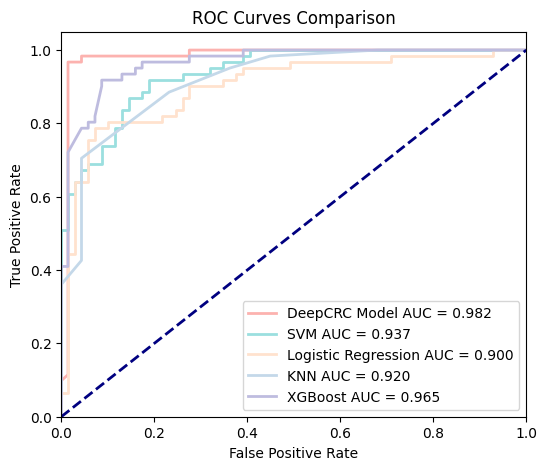

In [ ]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from torch.autograd import Variable


plt.rcParams.update({'font.size': 10})

def test_models(models, x_test, y_test):
    plt.figure(figsize=(6, 5))


    colors = ['#FCB2AF', '#9BDFDF', '#FFE2CE', '#C4D8E9', '#BEBCDF']

    for (name, model), color in zip(models.items(), colors):
        test_scores = []
        test_pred = []
        if isinstance(model, torch.nn.Module):
            # Handling PyTorch model
            model.eval()
            with torch.no_grad():
                for x in x_test:  # Assume x_test is properly batched or adjust accordingly
                    x = Variable(x.unsqueeze(0).float())  # Ensure input is correct for the model
                    output = model(x)
                    prob = torch.sigmoid(output)[:, 1]  # Assume binary classification and model outputs logits for each class
                    pred = torch.argmax(output, dim=1)
                    test_scores.extend(prob.cpu().numpy())  # Convert to numpy array and store
                    test_pred.extend(pred.cpu().numpy())
        else:
            # Handling sklearn models or XGBoost
            test_scores = model.predict_proba(x_test)[:, 1]
            test_pred = model.predict(x_test)

        # Compute ROC curve and ROC area for each model
        fpr, tpr, _ = roc_curve(y_test, test_scores)
        roc_auc = roc_auc_score(y_test, test_scores)
        plt.plot(fpr, tpr, color=color, lw=2, label=f'{name} AUC = {roc_auc:.3f}')

        # Optionally print accuracy and AUC
        accuracy = accuracy_score(y_test, test_pred)
        print(f"{name} - Accuracy: {accuracy:.4f}, AUC: {roc_auc:.4f}")

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend(loc="lower right")
    plt.show()

# Example usage
models = {
    'DeepCRC Model': model,
    'SVM': svm_model,
    'Logistic Regression': logistic_model,
    'KNN': knn_model,
    'XGBoost': xgb_model
}

# Assuming x_test and y_test are prepared
test_models(models, x_test, y_test)



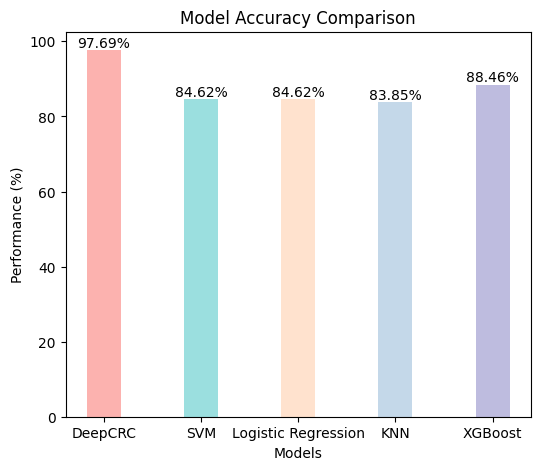

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.rcParams.update({'font.size': 10})

models = ['DeepCRC', 'SVM', 'Logistic Regression', 'KNN', 'XGBoost']

accuracies = [97.69, 84.62, 84.62, 83.85, 88.46]

# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
colors = ['#FCB2AF', '#9BDFDF', '#FFE2CE', '#C4D8E9', '#BEBCDF']

bar_width = 0.35
index = np.arange(len(models))

plt.figure(figsize=(6, 5))
bars = plt.bar(index, accuracies, bar_width, color=colors, label='Accuracy')

plt.xlabel('Models')
plt.ylabel('Performance (%)')
plt.title('Model Accuracy Comparison')
plt.xticks(index, models)

# plt.legend(prop={'size': 9})

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, '{:.2f}%'.format(height),
                 ha='center', va='bottom')

add_labels(bars)

plt.show()
